In [1]:
import geopandas as gpd
import pandas as pd
import os
import folium
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings(
    "ignore",
    message=".*choropleth_mapbox.*deprecated.*")


In [2]:
#leitura da geometria dos bairros
path='/home/akel/PycharmProjects/Data_ambiental/data/process/'
filename="shape_bairros.gpkg"
arquivo = os.path.join(path, filename)
gdf = gpd.read_file(arquivo).rename(columns={'NM_BAIRRO': 'Bairro'})

#leitura das Features
df = pd.read_csv(os.path.join(path,'tabela_total_final.csv'))
df_RF = pd.read_csv(os.path.join(path,'Descartes_RF.csv')).rename(columns={'Depósitos Irregulares est.': 'DIEs'})



#geometria +features
gdf_merged = gdf.merge(df, on="Bairro", how="left")
gdf_merged2 = gdf.merge(df_RF, on="Bairro", how="left")

#add nova feature
# Percentual Populacao_rendimento
gdf_merged['PPR']=gdf_merged['N_ren']/gdf_merged['Mor']
gdf_merged2['PPR']=gdf_merged2['N_ren']/gdf_merged2['Mor']


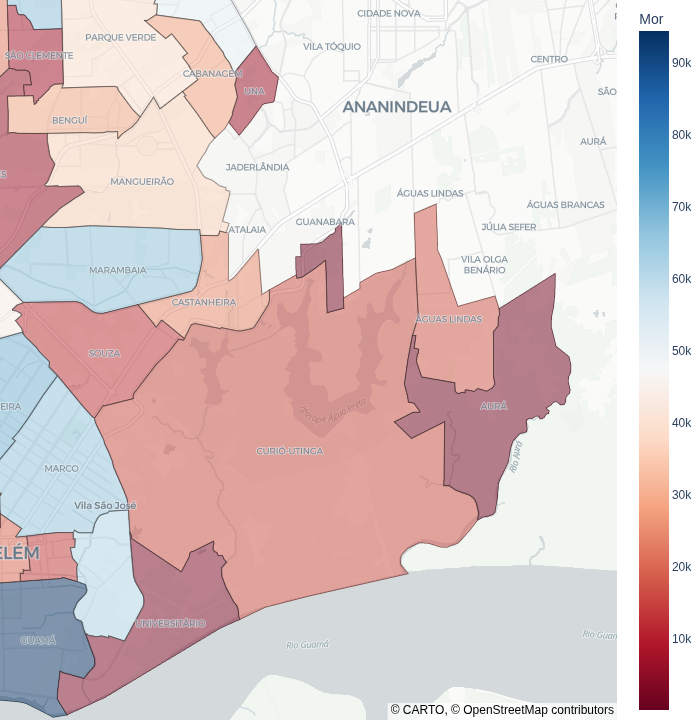

In [3]:
centro_lat,centro_lon =-1.417897, -48.4162631

fig = px.choropleth_map(
    gdf_merged,
    geojson=gdf_merged.geometry,
    locations=gdf_merged.index,
    color="Mor",
    color_continuous_scale="RdBu",
    zoom=12,
    opacity=0.5,
    hover_name="Bairro"
)

# Ajuste do tamanho da janela
fig.update_layout(
    map_style="carto-positron",
    map_center={"lat": centro_lat, "lon": centro_lon},
    height=720,
    margin={"r":0, "t":0, "l":0, "b":0}
)

# Salvar imagem
#fig.write_image("/home/akel/PycharmProjects/Data_ambiental/image/mapa_plotly.png", scale=1)

#fig.show(config={"scrollZoom": True})
fig.show('png')

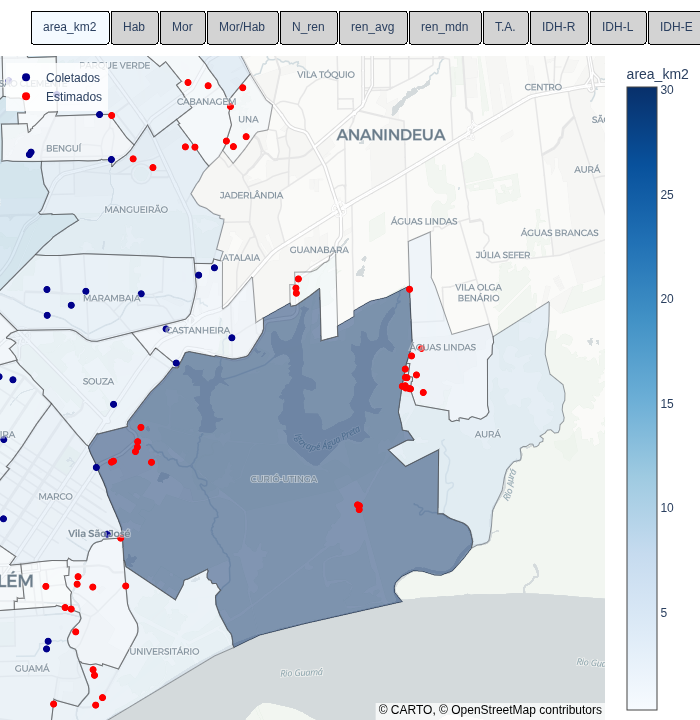

In [4]:
import plotly.express as px

filename2="Pontos_descartes_ML.gpkg"
path='/home/akel/PycharmProjects/Data_ambiental/data/process/'
arquivo2 = os.path.join(path, filename2)
gpd_p = gpd.read_file(arquivo2)

variaveis = ['area_km2','Hab','Mor','Mor/Hab','N_ren','ren_avg','ren_mdn','T.A.','IDH-R','IDH-L','IDH-E','IDH','PPR','DIEs']
escalas = ["blues", "reds", "reds", "reds", "RdYlGn", "RdYlGn", "RdYlGn","rdbu", "rdbu", "rdbu", "rdbu", "rdbu","rdbu",'RdYlGn_r']


# Juntando os dois gráficos em 1
fig = go.Figure()

# Adicionar um trace para cada variável do choropleth (inicialmente visível apenas o primeiro)
for i, (var, scale) in enumerate(zip(variaveis, escalas)):
    fig.add_trace(go.Choroplethmap(
        geojson=gdf_merged2.geometry.__geo_interface__,
        locations=gdf_merged2.index,
        z=gdf_merged2[var],
        colorscale=scale,
        visible=(i == 0),  # Apenas o primeiro visível
        marker_opacity=0.5,
        hovertext=gdf_merged2["Bairro"],
        hoverinfo="text+z",
        colorbar_title=var,
        name=var,
        showlegend=False
    ))

# Adicionar os pontos de descarte - DADOS
pontos_dados = gpd_p[gpd_p["Cor"] == "Dados"]
fig.add_trace(go.Scattermap(
    lat=pontos_dados["lat"],
    lon=pontos_dados["lon"],
    mode='markers',
    marker=dict(
        size=8,
        color="darkblue",
    ),
    hovertext=pontos_dados["Bairro"],
    hoverinfo="text",
    name="Coletados",
    showlegend=True,
    visible=True
))

# Adicionar os pontos de descarte - ESTIMADOS
pontos_estimados = gpd_p[gpd_p["Cor"] == "Estimados"]
fig.add_trace(go.Scattermap(
    lat=pontos_estimados["lat"],
    lon=pontos_estimados["lon"],
    mode='markers',
    marker=dict(
        size=8,
        color="red",
    ),
    hovertext=pontos_estimados["Bairro"],
    hoverinfo="text",
    name="Estimados",
    showlegend=True,
    visible=True
))

# Criar botões HORIZONTAIS apenas para as variáveis do choropleth
buttons = []
for i, var in enumerate(variaveis):
    visibility = [False] * len(variaveis) + [True, True]  # Ambos os pontos sempre visíveis
    visibility[i] = True  # Choropleth selecionado visível
    
    buttons.append(
        dict(
            label=var,
            method="update",
            args=[
                {"visible": visibility},
                {"title": f"Variável: {var}"}
            ]
        )
    )

# Calcular posições horizontais igualmente espaçadas
num_botoes = len(variaveis)
largura_botao = 0.12
espacamento = (1 - (largura_botao * num_botoes)) / (num_botoes + 1)

fig.update_layout(
    map_style="carto-positron",
    map_center={"lat": centro_lat, "lon": centro_lon},
    map_zoom=12,
    # Botões horizontais acima do mapa
    updatemenus=[
        dict(
            type="buttons",
            direction="right",  # Direção horizontal
            buttons=buttons,
            x=0.05,  # Posição inicial
            y=1.02,  # Acima do mapa
            xanchor="left",
            yanchor="bottom",
            bgcolor="lightgray",
            bordercolor="black",
            borderwidth=1,
            pad={"r": 10, "t": 10},
            showactive=True
        )
    ],
    height=720,
    margin={"r": 0, "t": 50, "l": 0, "b": 0},
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        bgcolor="rgba(255, 255, 255, 0.8)"
    )
)

#fig.show(config={"scrollZoom": True})
fig.show('png')

In [5]:
# # Configurar pandas para mostrar TODAS as linhas e colunas
# pd.set_option('display.max_rows', None)      # Mostrar todas as linhas
# pd.set_option('display.max_columns', None)   # Mostrar todas as colunas
# pd.set_option('display.width', None)         # Largura ilimitada
# pd.set_option('display.max_colwidth', None)  # Mostrar conteúdo completo das colunas

# # Agora exibir o DataFrame
# print("📊 DATAFRAME COMPLETO - gdf_merged2")
print("=" * 80)
#display(gdf_merged2)

# Alternativamente:
#gdf_merged
# A = gdf_merged2.drop(columns=["geometry"])
# A